In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch
from itertools import combinations

### Preprocess Data

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_10T', 
    freq=10,
    normalize_time=True,
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
    )

covar = locally_long_periodic + local_variation


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]


### Create, Train, and Perform Inference

In [4]:
"""
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_30T', 
    freq=30,
    normalize_time=True)

    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=kernel,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=True
)
"""

"\nfor kernel in covar_combinations:\n\n    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(\n    machine='entsorgung_30T', \n    freq=30,\n    normalize_time=True)\n\n    \n    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(\n    kernel_gen=kernel,\n    train_x=X_train,\n    train_y=y_train,\n    test_x=X_test,\n    test_y=y_test,\n    n_train=n_train,\n    training_iter=100,\n    lr=0.1, \n    time_agg='30T',\n    machine='entsorgung',\n    update_score=True\n)\n"

Iter 1 , Loss = 0.8349102161792133 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.7992954097565723 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.7634973889032524 , Noise = 0.5982165336608887
Iter 4 , Loss = 0.727565837182872 , Noise = 0.5543796420097351
Iter 5 , Loss = 0.691484088645203 , Noise = 0.5129516124725342
Iter 6 , Loss = 0.6551847080279096 , Noise = 0.4738905429840088
Iter 7 , Loss = 0.6186534626758858 , Noise = 0.4371476173400879
Iter 8 , Loss = 0.5819860241430721 , Noise = 0.40266671776771545
Iter 9 , Loss = 0.5453169554207784 , Noise = 0.37038537859916687
Iter 10 , Loss = 0.5087182593459404 , Noise = 0.34023499488830566
Iter 11 , Loss = 0.47214367458843043 , Noise = 0.3121415972709656
Iter 12 , Loss = 0.4354595955023524 , Noise = 0.2860259711742401
Iter 13 , Loss = 0.3985549564087047 , Noise = 0.2618042528629303
Iter 14 , Loss = 0.3614350602485447 , Noise = 0.2393886148929596
Iter 15 , Loss = 0.32424777755667183 , Noise = 0.21868830919265747
Iter 16 , Loss = 0.28726607978

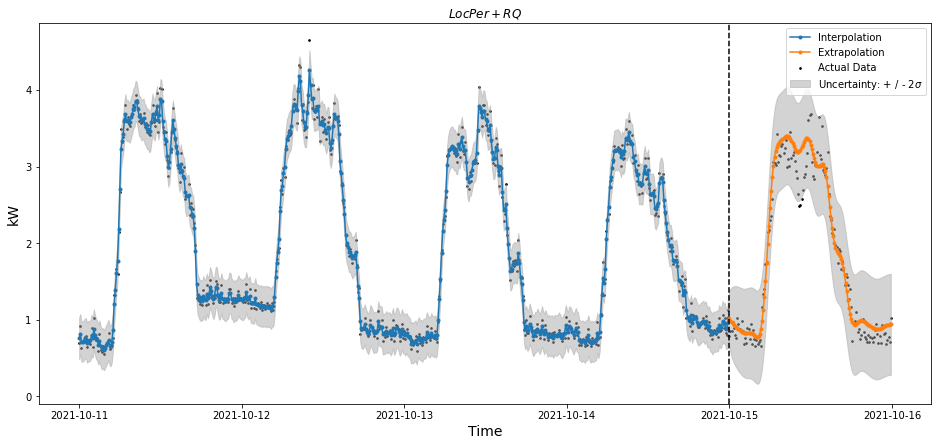

                 time    actual     machine
0 2021-10-11 06:10:00  3.488960  entsorgung
1 2021-10-12 10:00:00  4.647916  entsorgung
2 2021-10-13 15:00:00  2.776681  entsorgung


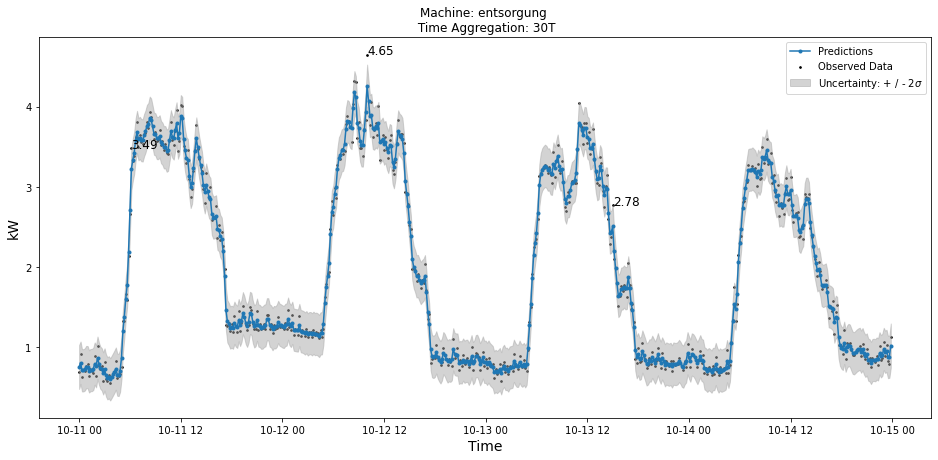

   index                time     machine control_limit  actual_kw  \
0      0 2021-10-15 13:10:00  entsorgung         upper   3.653058   
1      0 2021-10-15 10:20:00  entsorgung         lower   2.478373   
2      1 2021-10-15 10:30:00  entsorgung         lower   2.501013   
3      2 2021-10-15 10:40:00  entsorgung         lower   2.582069   

   expected_kw     bound  
0     3.004045  3.652727  
1     3.199410  2.557722  
2     3.219835  2.577657  
3     3.249105  2.606449  


/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:522: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:523: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:530: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[1].scatter(orig_time[c

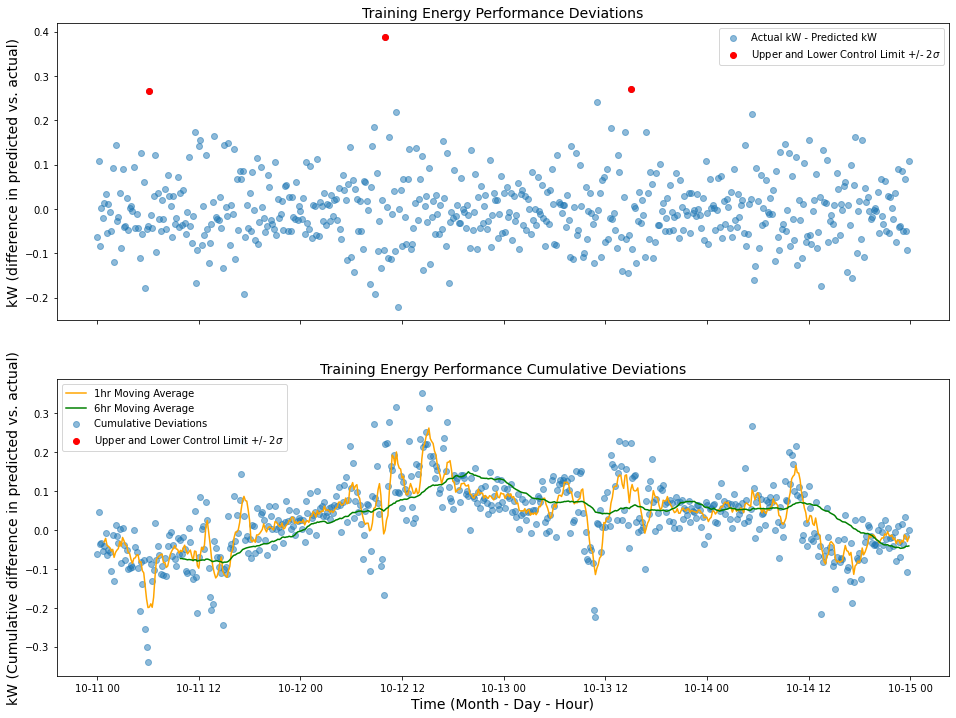

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:564: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:565: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:574: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

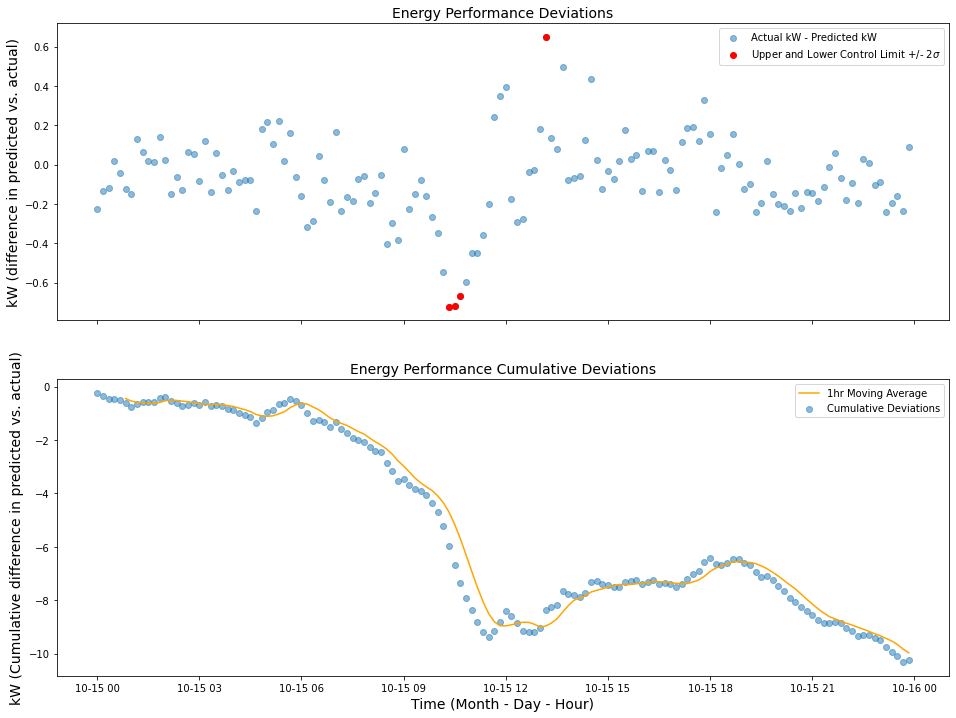

0.9722222222222222 0.08367708671776969


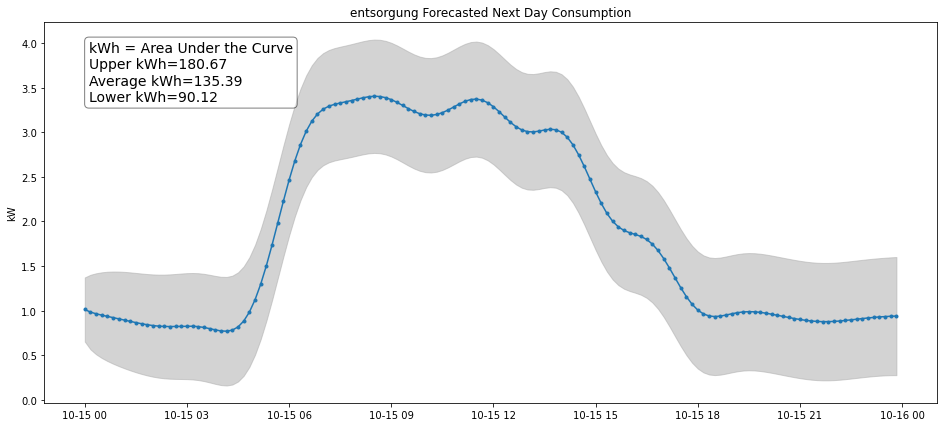

In [5]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=False
)

In [ ]:
mse, mape

### 5 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='5T',
    machine='entsorgung',
    update_score=False
)

In [ ]:
mse, mape